notebook for generating plots from section 6.1

In [1]:
%load_ext autoreload
%autoreload 2

#### model

In [ ]:
#hardware
device = 'cuda:0'

from circuit_explorer.utils import load_config
import torch
import os
from copy import deepcopy

config = load_config('../configs/alexnet_sparse_config.py')
model = config.model.to(device)


#### feature target

In [3]:
#dog/metal feature
layer = 'features.10'
unit = 9

#monkey/text feature
#layer = 'features.10'
#unit = 161

#### dataloading

In [4]:
image_root_folder = '../image_data/polysemantic/'+layer+':'+str(unit)+'/'


clusters = ['cluster_0','cluster_1']
#You can run the control experiment by uncommenting the following line:
#clusters = ['mixed_0','mixed_1']

if (clusters == ['mixed_0','mixed_1']) and not (os.path.exists(image_root_folder+'/mixed_0')):
    from circuit_explorer.utils import mix_image_folders
    mix_image_folders(image_root_folder,['cluster_0','cluster_1'],clusters)

from circuit_explorer.data_loading import rank_image_data
from torch.utils.data import DataLoader

dataloaders = {}
kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

for cluster in clusters:
    dataloaders[cluster] = DataLoader(rank_image_data(image_root_folder+'/'+cluster,
                                                      class_folders=False),
                                      batch_size=1,
                                      shuffle=False,
                                      **kwargs)


#### score

In [5]:
from circuit_explorer.score import actgrad_kernel_score

scores = {}

# we want to backprop the top activations in each image, this can be done by specifying a loss function that 
#operates on the output of each feature per batch 
loss_f = torch.max

for cluster in clusters:
    print(cluster)
    scores[cluster] = actgrad_kernel_score(model,dataloaders[cluster],layer,unit,loss_f = loss_f)

cluster_0
cluster_1


#### get original activations to images

In [6]:
from circuit_explorer.target import layer_activations_from_dataloader
from circuit_explorer.utils import actmap_maxpos

original_activations = {}
original_positions = {}
for cluster in clusters:
    target_layer_activations = layer_activations_from_dataloader(layer,dataloaders[cluster],model)[layer]
    unit_actmaps = target_layer_activations[:,unit]
    original_positions[cluster] = actmap_maxpos(unit_actmaps) #where in the activation map are we trying to preserve
    original_activations[cluster] = torch.amax(unit_actmaps,dim=(1, 2)) #what was the orig activation

#### check feature preservation

In [32]:
#calculate new circuit activations at different sparsities

import numpy as np
from circuit_explorer.mask import mask_from_scores, apply_mask
#from circuit_explorer.data_loading import single_image_data

sparsities = np.round(np.linspace(.4, .01, num=20),4)

sparsity_activations = {}
for circuit_cluster in clusters:
    print(circuit_cluster +' circuit')
    sparsity_activations[circuit_cluster+'_circuit'] = {}
    for data_cluster in clusters:
        print(data_cluster +' data')
        sparsity_activations[circuit_cluster+'_circuit'][data_cluster+'_data'] = []
        for sparsity in sparsities:
            print(sparsity) 
            activations = [] 
            mask = mask_from_scores(scores[circuit_cluster],sparsity = sparsity, model=model,unit=unit,target_layer=layer)
            apply_mask(model,mask)
            masked_layer_activations = layer_activations_from_dataloader(layer,dataloaders[data_cluster],model)[layer]
            for i in range(original_positions[data_cluster].shape[0]):
                position = original_positions[data_cluster][i]
                #get new activations at position
                activations.append(masked_layer_activations[i,unit,position[0],position[1]].half())
            #add those to the circuit activations at each sparsity
            sparsity_activations[circuit_cluster+'_circuit'][data_cluster+'_data'].append(activations)

cluster_0 circuit
cluster_0 data
0.4
0.3795
0.3589
0.3384
0.3179
0.2974
0.2768
0.2563
0.2358
0.2153
0.1947
0.1742
0.1537
0.1332
0.1126
0.0921
0.0716
0.0511
0.0305
0.01
cluster_1 data
0.4
0.3795
0.3589
0.3384
0.3179
0.2974
0.2768
0.2563
0.2358
0.2153
0.1947
0.1742
0.1537
0.1332
0.1126
0.0921
0.0716
0.0511
0.0305
0.01
cluster_1 circuit
cluster_0 data
0.4
0.3795
0.3589
0.3384
0.3179
0.2974
0.2768
0.2563
0.2358
0.2153
0.1947
0.1742
0.1537
0.1332
0.1126
0.0921
0.0716
0.0511
0.0305
0.01
cluster_1 data
0.4
0.3795
0.3589
0.3384
0.3179
0.2974
0.2768
0.2563
0.2358
0.2153
0.1947
0.1742
0.1537
0.1332
0.1126
0.0921
0.0716
0.0511
0.0305
0.01


In [33]:
import plotly.graph_objects as go
import plotly.express as px


color_dict = {
               clusters[0]+'_circuit':px.colors.qualitative.T10[0],
               clusters[1]+'_circuit':px.colors.qualitative.T10[1],
             }

fig = go.Figure()

for circuit in sparsity_activations:
    for data in sparsity_activations[circuit]:
        # Create and style traces
        if data.replace('_data','') == circuit.replace('_circuit',''):
            linetype = None
        else:
            linetype = 'dot'
            
        name = (circuit+' : '+data).replace('_',' ').replace('1','2').replace('0','1').replace('data','images')
        #get diff metric
        y = []
        for i in range(len(sparsity_activations[circuit][data])):
            circuit_acts = torch.tensor(sparsity_activations[circuit][data][i])
            orig_acts = original_activations[data.replace('_data','')]
            y.append(torch.mean(torch.abs(circuit_acts - orig_acts))/torch.mean(torch.abs(orig_acts)))

        x = sparsities
        fig.add_trace(go.Scatter(x=x, y=y, name=name,
                         line=dict(color=color_dict[circuit], width=4,dash=linetype)))

# Edit the layout
fig.update_layout( width = 720,
                   plot_bgcolor = 'rgba(255,255,255,1)',
                   paper_bgcolor = 'rgba(255,255,255,1)',
                   xaxis_title='sparsity',
                   yaxis_title=r'${\Delta\mathcal{F}_{norm}}$',
                  legend=dict(
                                yanchor="top",
                                y=0.95,
                                xanchor="left",
                                x=0.03,
                                bgcolor='rgba(255,255,255,0.3)'
                              )
                 )

fig.update_xaxes(autorange="reversed",gridcolor='rgb(210,210,210)',gridwidth=1)
fig.update_yaxes(gridcolor='rgb(210,210,210)',gridwidth=1)

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [.5, .4, .3, .2, .1]
    )
)


fig.show()

#### extract circuit at particular sparsity

In [39]:
from circuit_explorer.mask import mask_from_scores, apply_mask

# extraction at last good sparsity

target_sparsities = {'cluster_0':0.12,
                     'cluster_1':0.11
                    }


masks = {}

for cluster in clusters:
    masks[cluster] = mask_from_scores(scores[cluster],sparsity = target_sparsities[cluster], model=model,unit=unit,target_layer=layer)


##### feature visualization

original


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 79.51it/s]



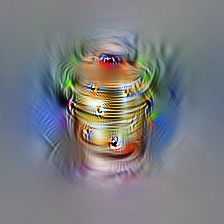

final loss: -88.479
cluster_0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 79.85it/s]



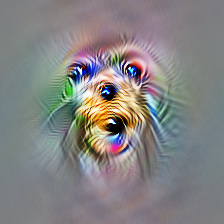

final loss: -134.323
cluster_1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 79.63it/s]



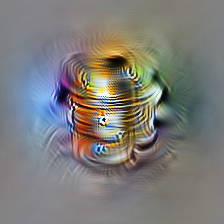

final loss: -59.944


In [40]:
from lucent_circuit.optvis import render, param, transform, objectives
from circuit_explorer.mask import setup_net_for_mask

setup_net_for_mask(model) #resets mask to all 1s

obj  = objectives.neuron(layer.replace('.','_'),unit)
param_f = lambda: param.image(224)

print('original')
_ = render.render_vis(model,obj,param_f)

for m in masks:
    apply_mask(model,masks[m])
    print(m)
    _ = render.render_vis(model,obj,param_f)

#### Compare IoU of extracted circuits

In [47]:
from circuit_explorer.utils import plot_iou_from_masks
iou_fig = plot_iou_from_masks(masks[clusters[0]],masks[clusters[1]])
iou_fig.show()